TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.



In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carga la imagen de las monedas
img = cv2.imread('monedas2.jpg')

# Convertir a RGB para visualizar
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convertir a escala de grises
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Aplicar un desenfoque para suavizar la imagen
img_gris = cv2.GaussianBlur(img_gris, (5, 5), 0)

# Umbralización (binarización)
_, img_th1 = cv2.threshold(img_gris, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Encontrar contornos
contornos, _ = cv2.findContours(img_th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Definir diámetros conocidos de monedas en mm
monedas = {
    25.75: 2.0,    # 2 euros
    23.25: 1.0,    # 1 euro
    24.35: 0.5,    # 50 céntimos
    22.25: 0.2,    # 20 céntimos
    19.75: 0.1,    # 10 céntimos
    21.25: 0.05,   # 5 céntimos
    18.75: 0.02,   # 2 céntimos
    16.26: 0.01    # 1 céntimo
}

# Variables para almacenar posiciones y diámetros de las monedas detectadas
monedas_detectadas = []

# Recorrer los contornos y calcular el diámetro
for c in contornos:
    area = cv2.contourArea(c)
    if area > 10:
        (cx, cy), radio = cv2.minEnclosingCircle(c)
        diametro_px = 2 * radio
        monedas_detectadas.append(((int(cx), int(cy)), diametro_px))

# Variable para guardar el factor de conversión
factor_conversion = None

# Función para manejar clics del ratón
def seleccionar_moneda(event, x, y, flags, param):
    global factor_conversion
    
    if event == cv2.EVENT_LBUTTONDOWN:
        # Verificar si el clic está cerca de alguna moneda detectada
        for (pos, diametro_px) in monedas_detectadas:
            cx, cy = pos
            radio = diametro_px / 2
            
            # Verificar si el clic está dentro del radio de una moneda
            if np.sqrt((x - cx) ** 2 + (y - cy) ** 2) < radio:
                # Asumimos que la moneda seleccionada es la referencia
                diametro_mm = 25.75  # Asumimos que el usuario selecciona la moneda de 2 euros
                factor_conversion = diametro_mm / diametro_px
                print(f"Moneda seleccionada en ({cx}, {cy}) con diámetro de {diametro_px:.2f} px.")
                print(f"Factor de conversión actualizado: {factor_conversion:.4f} mm/px")
                break

# Mostrar la imagen y registrar el callback para eventos de ratón
cv2.imshow('Selecciona una moneda de referencia', img)
cv2.setMouseCallback('Selecciona una moneda de referencia', seleccionar_moneda)
# Mostrar las monedas detectadas en la imagen original
for (pos, diametro_px) in monedas_detectadas:
    cx, cy = pos
    cv2.circle(img_rgb, (cx, cy), int(diametro_px / 2), (255, 0, 0), 2)  # Dibuja el contorno en azul

# Mostrar el resultado en la ventana
cv2.imshow('Monedas Detectadas', img_rgb)
# Esperar hasta que el usuario cierre la ventana
cv2.waitKey(0)
cv2.destroyAllWindows()

# Verificar si el usuario seleccionó una moneda
if factor_conversion is None:
    print("No se seleccionó ninguna moneda.")
    exit()

# Ahora que tenemos el factor de conversión, procesamos las monedas detectadas
total_monedas = 0
total_dinero = 0.0

# Volver a recorrer los contornos y calcular el valor de las monedas
for c in contornos:
    area = cv2.contourArea(c)
    
    if area > 10:
        (cx, cy), radio = cv2.minEnclosingCircle(c)
        diametro_px = 2 * radio
        
        # Convertimos el diámetro de píxeles a milímetros usando el factor de conversión
        diametro_mm = diametro_px * factor_conversion
        
        # Buscamos la denominación de la moneda según su diámetro
        moneda_valor = None
        for diametro_moneda, valor in monedas.items():
            if abs(diametro_mm - diametro_moneda) < 0.75:  # Tolerancia de 0.75 mm
                moneda_valor = valor
                break
        
        # Si encontramos una moneda válida, sumamos al total
        if moneda_valor is not None:
            total_monedas += 1
            total_dinero += moneda_valor
            print(f"Moneda detectada: {moneda_valor} euros, Diámetro: {diametro_mm:.2f} mm")

# Mostramos el resultado final
print(f"Total de monedas: {total_monedas}")
print(f"Cantidad total de dinero: {total_dinero:.2f} euros")

Moneda seleccionada en (111, 108) con diámetro de 128.66 px.
Factor de conversión actualizado: 0.2001 mm/px
Moneda detectada: 2.0 euros, Diámetro: 25.75 mm
Total de monedas: 1
Cantidad total de dinero: 2.00 euros


TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
imgF_col = cv2.imread('fragment_photo.jpg') 
imgP_col = cv2.imread('pellet_photo.jpg')
imgT_col = cv2.imread('tar_photo.jpg')

hsv_imgF = cv2.cvtColor(imgF_col, cv2.COLOR_BGR2HSV)
hsv_imgP = cv2.cvtColor(imgP_col, cv2.COLOR_BGR2HSV)
hsv_imgT = cv2.cvtColor(imgT_col, cv2.COLOR_BGR2HSV)

In [5]:
# Funzione per estrarre caratteristiche di forma e colore
def extractFeatures(contours, hsv_img):
    shape_features = []
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)      
              
        # Calcolo della circolarità
        circularity = (4 * np.pi * area) / (perimeter ** 2)  # Formula della circolarità

        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio =float(w)/h

        height, width = hsv_img.shape[:2]
        binary_mask = np.zeros((height, width), dtype=np.uint8)

        cv2.drawContours(binary_mask, [contour], -1, (255), thickness=cv2.FILLED)  

        # Calcolo la media per ogni canale HSV usando la maschera binaria
        mean_hsv = cv2.mean(hsv_img, mask=binary_mask)
        
        compactness = (perimeter ** 2) / (4 * np.pi * area)

        shape_features.append({
               'circularity': circularity,
               'mean_hsv': mean_hsv,
               'compactness': compactness,
               'aspect_ratio': aspect_ratio
               })
    
    return shape_features

In [6]:
# Funzione per classificare in base alle caratteristiche
def classify(features):
    classifications = []
    for feature in features:
        circularity = feature['circularity']
        mean_hsv = feature['mean_hsv']
        compactness = feature['compactness']

        if mean_hsv[2] > 55:
            if circularity > 0.8:
                classifications.append('Pellet')
            else:
                classifications.append('Fragment')
        else:
            classifications.append('Alquitran')

    return classifications

In [7]:
# Carica l'immagine in scala di grigi
imgF = cv2.imread('fragment_photo.jpg', cv2.IMREAD_GRAYSCALE) 
imgP = cv2.imread('pellet_photo.jpg', cv2.IMREAD_GRAYSCALE)
imgT = cv2.imread('tar_photo.jpg', cv2.IMREAD_GRAYSCALE)

# Applica un filtro Gaussiano per ridurre il rumore
imgF_gaus = cv2.GaussianBlur(imgF, (5,5), 0)
imgP_gaus = cv2.GaussianBlur(imgP, (5,5), 0)
imgT_gaus = cv2.GaussianBlur(imgT, (5,5), 0)

# Applico Otsu
thotsuF,imthF = cv2.threshold(imgF_gaus,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsuF)
kernelF = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated_imageF = cv2.dilate(imthF, kernelF, iterations=4)
eroded_imageF = cv2.erode(dilated_imageF, kernelF, iterations=4)

thotsuP,imthP = cv2.threshold(imgP_gaus,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsuP)

thotsuT,imthT = cv2.threshold(imgT_gaus,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsuT)

Umbral escogido  122.0
Umbral escogido  111.0
Umbral escogido  71.0


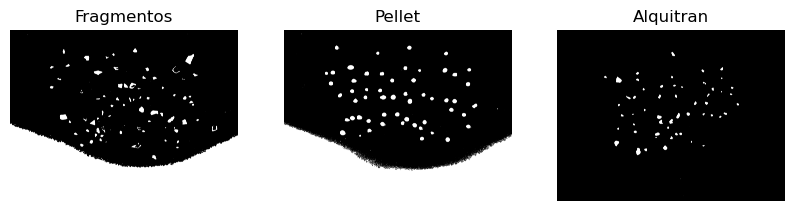

In [8]:
# Ottiene i contorni esterni
contornosF, hierarchyF = cv2.findContours(eroded_imageF, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contornosP, hierarchyP = cv2.findContours(imthP, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contornosT, hierarchyT = cv2.findContours(imthT, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crea un'immagine vuota per disegnare i contorni
imgF_cont = np.zeros(imgF_gaus.shape)
cv2.drawContours(imgF_cont, contornosF, -1, (255, 255, 255), -1)  # Disegna i contorni riempiti

imgP_cont = np.zeros(imgP_gaus.shape)
cv2.drawContours(imgP_cont, contornosP, -1, (255, 255, 255), -1)

imgT_cont = np.zeros(imgT_gaus.shape)
cv2.drawContours(imgT_cont, contornosT, -1, (255, 255, 255), -1)

plt.figure(figsize=(10, 5))

# Visualizza l'immagine con i contorni
plt.subplot(1, 3, 1)
plt.imshow(imgF_cont, 'gray')
plt.title('Fragmentos')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(imgP_cont, 'gray')
plt.title('Pellet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(imgT_cont, 'gray')
plt.title('Alquitran')
plt.axis('off')

# Mostra i risultati
plt.show()

In [9]:
def calcAreaToExtractList(contornos, name):
    list = [] 
    i=0
    for contour in contornos:
            area = cv2.contourArea(contour)
            
            if(area > 1000 and area < 10000):
                print(f"{name} {i+1}: Area = {area:.2f}")
                i+=1           
                list.append(contour)
    return list

In [10]:
listF = calcAreaToExtractList(contornosF, 'Fragment')
listP = calcAreaToExtractList(contornosP, 'Pellet')

shape_features_F = extractFeatures(listF, hsv_imgF)
shape_features_P = extractFeatures(listP, hsv_imgP)
shape_features_T = extractFeatures(contornosT, hsv_imgT)

Fragment 1: Area = 4743.50
Fragment 2: Area = 1138.00
Fragment 3: Area = 4518.50
Fragment 4: Area = 2920.00
Fragment 5: Area = 1588.50
Fragment 6: Area = 3787.00
Fragment 7: Area = 1267.50
Fragment 8: Area = 1976.00
Fragment 9: Area = 2155.50
Fragment 10: Area = 2281.50
Fragment 11: Area = 2232.00
Fragment 12: Area = 2684.00
Fragment 13: Area = 1520.00
Fragment 14: Area = 2341.00
Fragment 15: Area = 4045.00
Fragment 16: Area = 5228.00
Fragment 17: Area = 1766.50
Fragment 18: Area = 2311.50
Fragment 19: Area = 4683.00
Fragment 20: Area = 1656.50
Fragment 21: Area = 1349.50
Fragment 22: Area = 6641.50
Fragment 23: Area = 7450.00
Fragment 24: Area = 1511.50
Fragment 25: Area = 1679.50
Fragment 26: Area = 1166.50
Fragment 27: Area = 8835.00
Fragment 28: Area = 1020.50
Fragment 29: Area = 2881.50
Fragment 30: Area = 2542.00
Fragment 31: Area = 8684.00
Fragment 32: Area = 2024.00
Fragment 33: Area = 1293.00
Fragment 34: Area = 1376.00
Fragment 35: Area = 2542.50
Fragment 36: Area = 1002.00
F

In [11]:
def printFeatures(features, name):
    for idx, feature in enumerate(features):
        circularity, mean_hsv, compactness, aspect_ratio = feature.values()
        print(f"{name} {idx+1}: Circularity = {circularity:.3f}, Mean value = {mean_hsv[2]:.2f}, Compactness = {compactness:.2f}, aspect_ratio = {aspect_ratio:.2f}") 
        

printFeatures(shape_features_F, 'Fragment')
printFeatures(shape_features_P, 'Pellet')
printFeatures(shape_features_T, 'Alquitran')

Fragment 1: Circularity = 0.638, Mean value = 98.13, Compactness = 1.57, aspect_ratio = 1.02
Fragment 2: Circularity = 0.750, Mean value = 117.36, Compactness = 1.33, aspect_ratio = 1.45
Fragment 3: Circularity = 0.135, Mean value = 121.79, Compactness = 7.41, aspect_ratio = 2.75
Fragment 4: Circularity = 0.816, Mean value = 111.09, Compactness = 1.23, aspect_ratio = 1.16
Fragment 5: Circularity = 0.629, Mean value = 120.95, Compactness = 1.59, aspect_ratio = 0.83
Fragment 6: Circularity = 0.824, Mean value = 115.96, Compactness = 1.21, aspect_ratio = 0.93
Fragment 7: Circularity = 0.763, Mean value = 74.49, Compactness = 1.31, aspect_ratio = 1.10
Fragment 8: Circularity = 0.791, Mean value = 111.81, Compactness = 1.26, aspect_ratio = 0.84
Fragment 9: Circularity = 0.756, Mean value = 71.06, Compactness = 1.32, aspect_ratio = 1.36
Fragment 10: Circularity = 0.738, Mean value = 118.29, Compactness = 1.35, aspect_ratio = 0.75
Fragment 11: Circularity = 0.667, Mean value = 107.57, Compact

In [12]:
# Funzione per estrarre e calcolare i valori richiesti usando NumPy
def calculateStatisticsWithNumpy(features, name):
    # Estrazione dei valori come array NumPy
    circularity_values = np.array([feature['circularity'] for feature in features])
    mean_values = np.array([feature['mean_hsv'][2] for feature in features])  # Usando il valore V (indice 2)
    compactness_values = np.array([feature['compactness'] for feature in features])
    aspect_ratio_values = np.array([feature['aspect_ratio'] for feature in features])

    # Calcolo di min, max e media con NumPy
    circularity_stats = (np.min(circularity_values), np.max(circularity_values), np.mean(circularity_values))
    mean_value_stats = (np.min(mean_values), np.max(mean_values), np.mean(mean_values))
    compactness_stats = (np.min(compactness_values), np.max(compactness_values), np.mean(compactness_values))
    aspect_ratio_stats = (np.min(aspect_ratio_values), np.max(aspect_ratio_values), np.mean(aspect_ratio_values))

    # Stampa dei risultati
    print(f"Statistics for {name}:")
    print(f"Circularity: Min = {circularity_stats[0]:.3f}, Max = {circularity_stats[1]:.3f}, Mean = {circularity_stats[2]:.3f}")
    print(f"Mean Value (V): Min = {mean_value_stats[0]:.2f}, Max = {mean_value_stats[1]:.2f}, Mean = {mean_value_stats[2]:.2f}")
    print(f"Compactness: Min = {compactness_stats[0]:.2f}, Max = {compactness_stats[1]:.2f}, Mean = {compactness_stats[2]:.2f}")
    print(f"Aspect Ratio: Min = {aspect_ratio_stats[0]:.2f}, Max = {aspect_ratio_stats[1]:.2f}, Mean = {aspect_ratio_stats[2]:.2f}")
    print("\n")

# Esempio di utilizzo
calculateStatisticsWithNumpy(shape_features_F, 'Fragment')
calculateStatisticsWithNumpy(shape_features_P, 'Pellet')
calculateStatisticsWithNumpy(shape_features_T, 'Alquitran')

Statistics for Fragment:
Circularity: Min = 0.093, Max = 0.839, Mean = 0.631
Mean Value (V): Min = 58.70, Max = 136.31, Mean = 107.55
Compactness: Min = 1.19, Max = 10.78, Mean = 2.13
Aspect Ratio: Min = 0.37, Max = 3.04, Mean = 1.17


Statistics for Pellet:
Circularity: Min = 0.380, Max = 0.885, Mean = 0.784
Mean Value (V): Min = 51.13, Max = 107.64, Mean = 87.04
Compactness: Min = 1.13, Max = 2.63, Mean = 1.32
Aspect Ratio: Min = 0.91, Max = 1.62, Mean = 1.12


Statistics for Alquitran:
Circularity: Min = 0.530, Max = 0.888, Mean = 0.780
Mean Value (V): Min = 20.98, Max = 62.33, Mean = 30.55
Compactness: Min = 1.13, Max = 1.89, Mean = 1.29
Aspect Ratio: Min = 0.63, Max = 1.60, Mean = 1.03




In [13]:
# Classifica le particelle
classificationsF = classify(shape_features_F)
classificationsP = classify(shape_features_P)
classificationsT = classify(shape_features_T)

# Visualizza le classificazioni per verifica
print("Classificazioni Fragmentos:", classificationsF)
print("Classificazioni Pellet:", classificationsP)
print("Classificazioni Alquitrán:", classificationsT)

Classificazioni Fragmentos: ['Fragment', 'Fragment', 'Fragment', 'Pellet', 'Fragment', 'Pellet', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Pellet', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Pellet', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Pellet', 'Fragment', 'Pellet', 'Fragment', 'Fragment', 'Pellet', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment']
Classificazioni Pellet: ['Pellet', 'Pellet', 'Pellet', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Fragment', 'Pellet', 'Alqui

Anotaciones  ['Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Fragment', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pellet', 'Pel

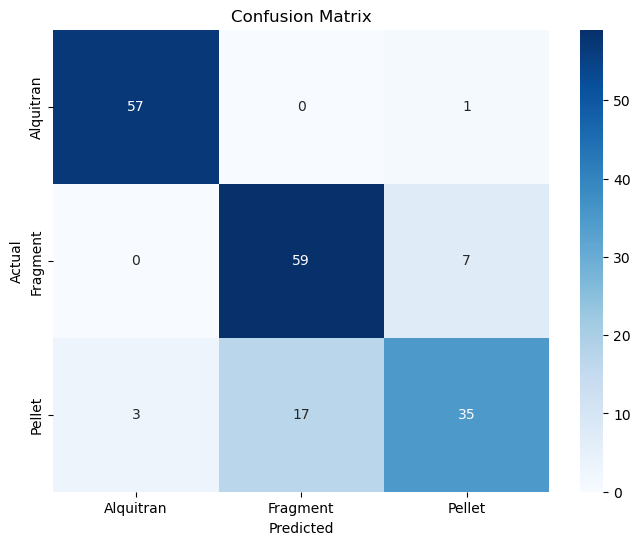

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)



# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas

realF = ["Fragment" for frag in classificationsF]
realP = ["Pellet" for pellet in classificationsP]
realT = ["Alquitran" for t in classificationsT]
y = realF + realP + realT
print('Anotaciones ' , y)

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = classificationsF + classificationsP + classificationsT
print('Predicciones ' , y_pred)

print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


labels = sorted(list(set(y + y_pred)))

# Creo la confusion matrix
cm = confusion_matrix(y, y_pred, labels=labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)


plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


plt.show()